In [31]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
from imp import reload
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from sys import stdout

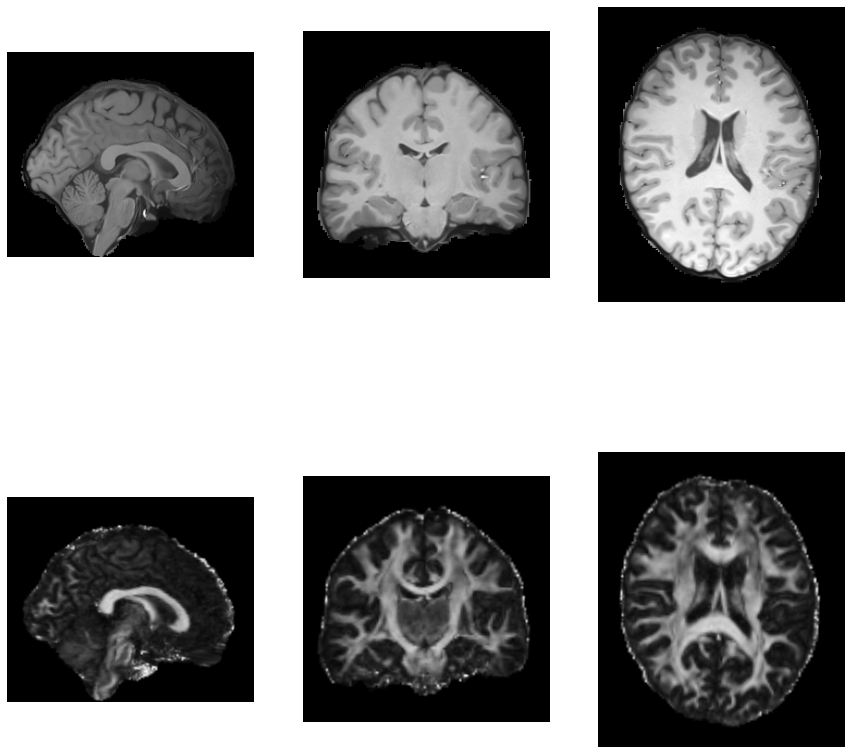

In [4]:
### units for data preprocession
# reload(units.base)
from GAN.dataloader import load_pair
from units.base import visualize,generate_images
DEBUG=True

t1,fa=load_pair(r"./datasets/brainmap/paired/9")
# t1[fa==0]=0
visualize([t1,fa],save_path="demo/paired.png")
# visualize(fa)

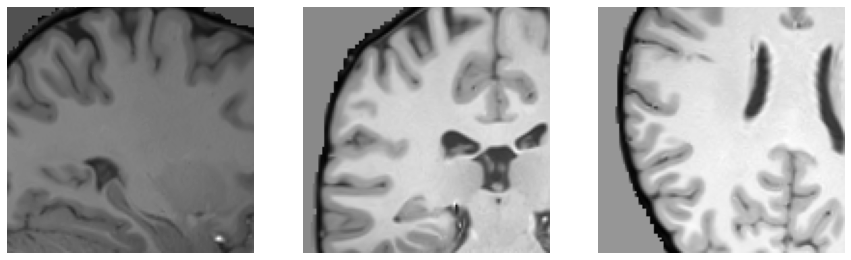

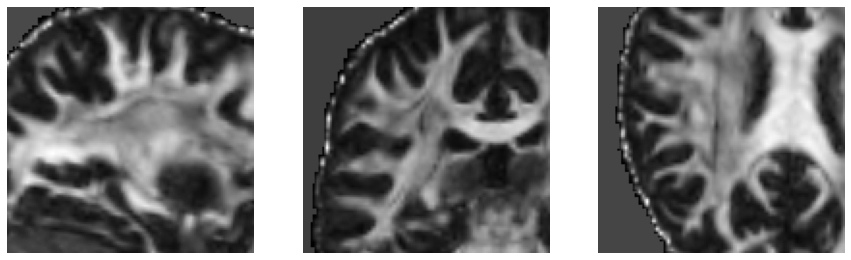

In [5]:
### visualize argument
# reload(GAN.prep)
from GAN.prep import random_jitter

# for i in range(1):
t1_arg,fa_arg=t1,fa#Patch_extration()(t1,fa)
t1_arg,fa_arg=random_jitter(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
visualize(t1_arg)
visualize(fa_arg)
np.save("demo/t1_arg",t1_arg)
np.save("demo/fa_arg",fa_arg)

In [7]:
### train_test_split
# DEBUG=True
DATAPATH = "./datasets/brainmap/paired"
data=[f"{DATAPATH}/{imgdir}"for imgdir in os.listdir(DATAPATH)]
if DEBUG:data=data[:10]
# print(data)
from sklearn.model_selection import train_test_split
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
# train
print(f"Train len: {len(train)}")
print(f"Val len: {len(val)}")
print(f"Test len: {len(test)}")

Train len: 8
Val len: 1
Test len: 1


In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 4
import GAN
reload(GAN)
from GAN.dataloader import load_image_train,load_image_test
from tqdm import tqdm
# print(f"train_dataset: {len(train_dataset)}")
def get_train_ds(train):
    # train_dataset=[]
    # for t in tqdm(train):
        # train_dataset.append(load_image_train(t))
    # train_dataset=np.array(train_dataset)
    # train_dataset = list(map(load_image_train,train))
    train_dataset = tf.data.Dataset.from_tensor_slices(train)
    # train_dataset=load_image_train(train)
    train_dataset = train_dataset.map(lambda x:tf.numpy_function(func=load_image_train,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE,seed=114514)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    return train_dataset
# train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))

def get_test_ds(test):
    test_dataset=[]
    for i in range(8):test_dataset+=[load_image_test(test_dir)for test_dir in test]
    iplist,relist=[],[]
    for input,real in test_dataset:
        iplist.append(input)
        relist.append(real)
    test_dataset = tf.data.Dataset.from_tensor_slices((iplist,relist))
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    return test_dataset

train_ds,val_ds,test_ds=get_train_ds(train),get_test_ds(val),get_test_ds(test)

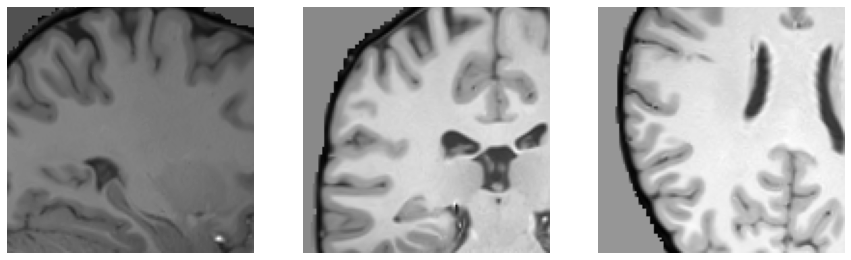

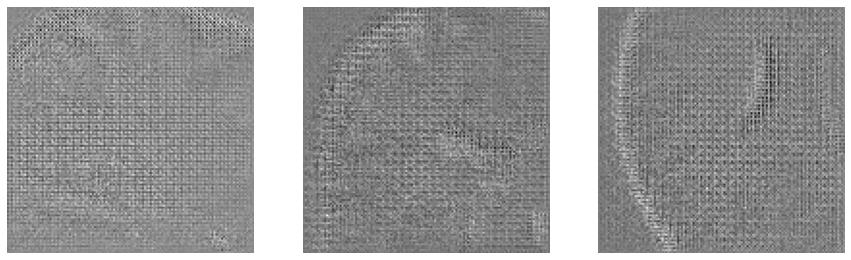

In [9]:
# del Generator
# reload(GAN)
import GAN
reload(GAN.model)
tip=t1_arg[tf.newaxis, ...]
tg=GAN.model.Generator()
gen_output = tg(tip, training=False)
# print(gen_output.shape)
visualize(tip[0,:,:,:])
visualize(gen_output[0,:,:,:,0])
# print(np.average(gen_output[0,:,:,:,0].numpy()))

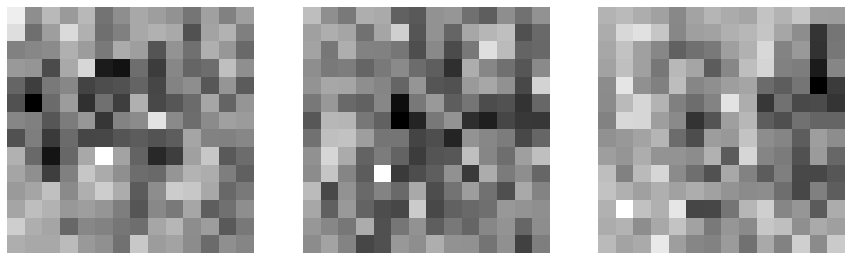

In [10]:
from GAN.model import Generator,Discriminator
ds=Discriminator()
tip,fip=t1_arg[tf.newaxis, ...],fa_arg[tf.newaxis, ...]
disc_output = ds([tip,fip], training=False)
# print(gen_output.shape)
# visualize(tip[0,:,:,:])
visualize(disc_output[0,:,:,:,0])


(128, 128, 128) (128, 128, 128) (128, 128, 128, 1)


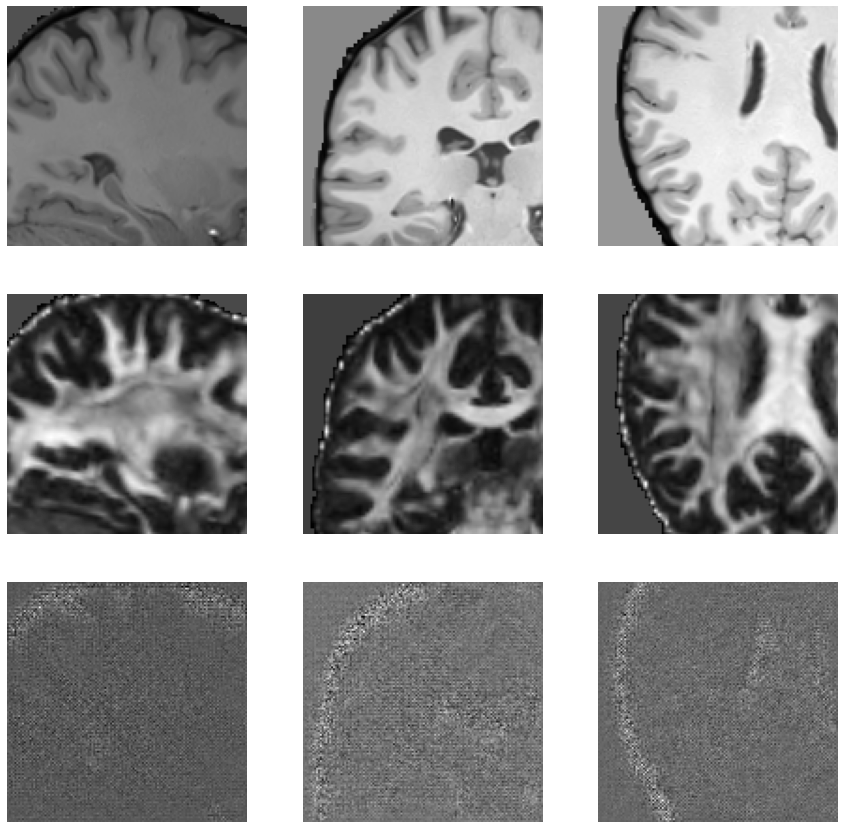

In [11]:
# reload(GAN)
generator=Generator()
generate_images(generator,tip,fip)

In [19]:
gen_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

from GAN.model import Generator,Discriminator
# reload(GAN.model)
generator = Generator()
discriminator=Discriminator()
from GAN.loss import get_gen_loss,get_disc_loss
# reload(GAN.loss)


In [37]:
log_dir="logs/"
this_log_dir=log_dir + "GAN_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(this_log_dir)
path=f"{this_log_dir}/T1_FA"
checkpoint_dir = f"{this_log_dir}/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_oper,
                                 discriminator_optimizer=disc_oper,
                                 generator=generator,
                                 discriminator=discriminator)


In [38]:
ALPHA=5
G,D=generator,discriminator
@tf.function
def train_step(img, tar, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        tar_fake = G(img, training=True)

        disc_real_output = D([img, tar], training=True)
        disc_fake_output = D([img, tar_fake], training=True)

        gen_loss, dice_loss, gan_disc_loss = get_gen_loss(
            tar,tar_fake,disc_fake_output, ALPHA)
        disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_grad = gen_tape.gradient(
        gen_loss, G.trainable_variables)
    disc_grad = disc_tape.gradient(
        disc_loss, D.trainable_variables)

    gen_oper.apply_gradients(
        zip(gen_grad, G.trainable_variables))
    disc_oper.apply_gradients(
        zip(disc_grad, D.trainable_variables))

    
    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step)
        tf.summary.scalar('dice_loss', dice_loss, step)
        tf.summary.scalar('gan_disc_loss', gan_disc_loss,step)
        tf.summary.scalar('disc_loss', disc_loss,step)
    return gen_loss, dice_loss, gan_disc_loss, disc_loss

In [39]:
@tf.function
def test_step(img, tar):
    tar_fake = G(img, training=False)

    disc_real_output = D([img, tar], training=False)
    disc_fake_output = D([img, tar_fake], training=False)
    disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_loss, dice_loss, gan_disc_loss = get_gen_loss(tar, tar_fake, disc_fake_output, ALPHA)
        
    return gen_loss, dice_loss, gan_disc_loss, disc_loss

In [40]:
val_time=100

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    history = {'train': [], 'valid': []}
    prev_loss = np.inf

    train_losses=[tf.keras.metrics.Mean() for i in range(4)]
    test_losses=[tf.keras.metrics.Mean() for i in range(4)]

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():

        start = time.time()
        print('Epoch {}/{}'.format(step+1,steps))

        # if (step+1) % 1 == 0:
            # display.clear_output(wait=True)
            # generate_images(generator, example_input, example_target)

        train_step_loss=train_step(input_image, target, step)
        for meti,li in zip(train_losses,train_step_loss):meti.update_state(li)
        gen_loss, dice_loss, gan_disc_loss, disc_loss=[x.result() for x in train_losses]

        stdout.write(f'\rStep: {step+1}/{steps} - loss: {gen_loss:.6f} - dice_loss: {dice_loss:.6f} - gan_disc_loss: {gan_disc_loss:.6f} - disc_loss: {disc_loss:.6f}')
        
        print(f'Time taken for 1 steps: {time.time()-start:.2f} sec\n')
        stdout.flush()
        
        if (step+1) % val_time==0:
            
            for step, (input_image, target) in test_ds.enumerate():
                test_step_loss=test_step(input_image, target)
                for meti,li in zip(test_losses,test_step_loss):meti.update_state(li)
            
            gen_loss_val, dice_loss_val, gan_disc_loss_val, disc_loss_val=[x.result() for x in test_losses]
            stdout.write(f'\rVal_step: {(step+1)//val_time}/{steps//val_time} - val_loss: {gen_loss_val:.6f} - val_dice_loss: {dice_loss_val:.6f} - val_gan_disc_loss: {gan_disc_loss_val:.6f} - val_disc_loss: {disc_loss_val:.6f}')


            save_path=f"{path}/step_{step:03d}"
            os.makedirs(save_path,exist_ok=True)
            
            generate_images(G,example_input, example_target,save_path=f"{save_path}/show.png")
            G.save_weights(f"{save_path}/G.h5") 
            D.save_weights(f"{save_path}/D.h5") 

            if gen_loss_val < prev_loss:    
                G.save_weights(f"{path}/Generator.h5") 
                D.save_weights(f"{path}/Generator.h5") 
                print(f"Validation loss decresaed from {prev_loss:.4f} to {gen_loss_val:.4f}. Models' weights are now saved.")
                prev_loss=gen_loss_val
            else:
                print(f"Validation loss did not decrese from {prev_loss:.4f} to {gen_loss_val:.4f}.")

            history['train'].append([x.result() for x in train_losses])
            history['valid'].append([x.result() for x in test_losses])
            for x in train_losses:x.reset_states()
            for x in test_losses:x.reset_states()
            checkpoint.save(file_prefix=checkpoint_prefix)
    return history

Val_step: 0/2 - val_loss: -4.046928 - val_dice_loss: -1.008454 - val_gan_disc_loss: 0.995343 - val_disc_loss: 0.917279(128, 128, 128) (128, 128, 128) (128, 128, 128, 1)


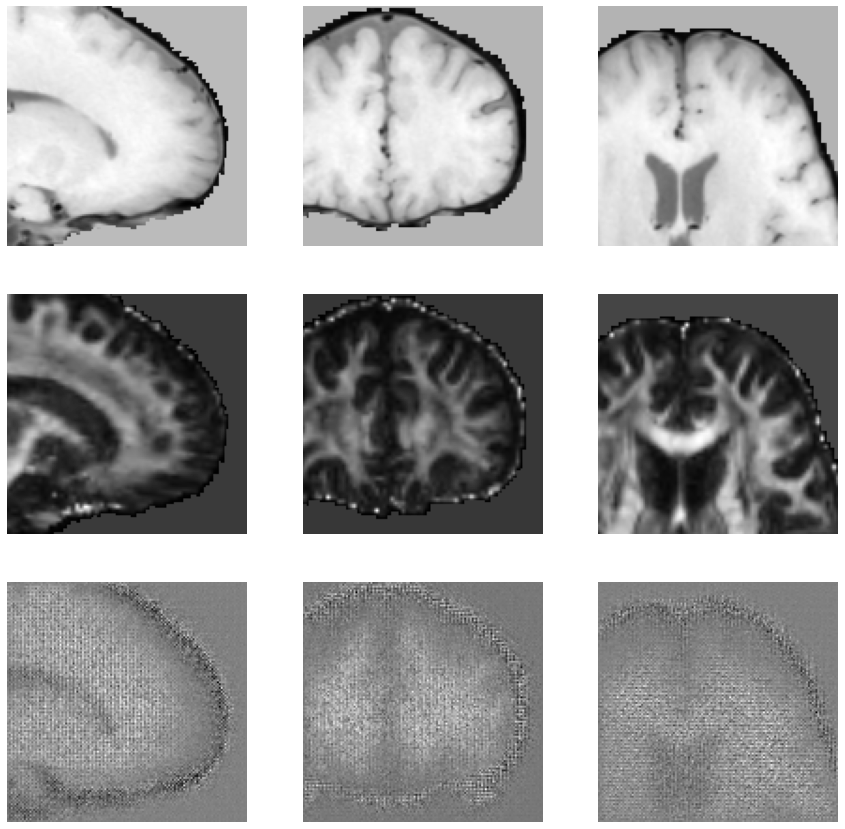

Validation loss decresaed from inf to -4.0469. Models' weights are now saved.
Epoch 2/10
Step: 2/10 - loss: -2.843589 - dice_loss: -0.770698 - gan_disc_loss: 1.009903 - disc_loss: 0.994018Time taken for 1 steps: 134.58 sec

Epoch 2/10
Step: 2/10 - loss: -5.915100 - dice_loss: -1.388277 - gan_disc_loss: 1.026287 - disc_loss: 0.974848Time taken for 1 steps: 39.90 sec

Epoch 3/10
Step: 3/10 - loss: -7.075702 - dice_loss: -1.610570 - gan_disc_loss: 0.977147 - disc_loss: 0.948092Time taken for 1 steps: 90.08 sec

Epoch 4/10
Step: 4/10 - loss: -8.537078 - dice_loss: -1.901859 - gan_disc_loss: 0.972214 - disc_loss: 0.920094Time taken for 1 steps: 49.03 sec

Val_step: 0/2 - val_loss: -10.521267 - val_dice_loss: -2.294162 - val_gan_disc_loss: 0.949543 - val_disc_loss: 0.685572(128, 128, 128) (128, 128, 128) (128, 128, 128, 1)


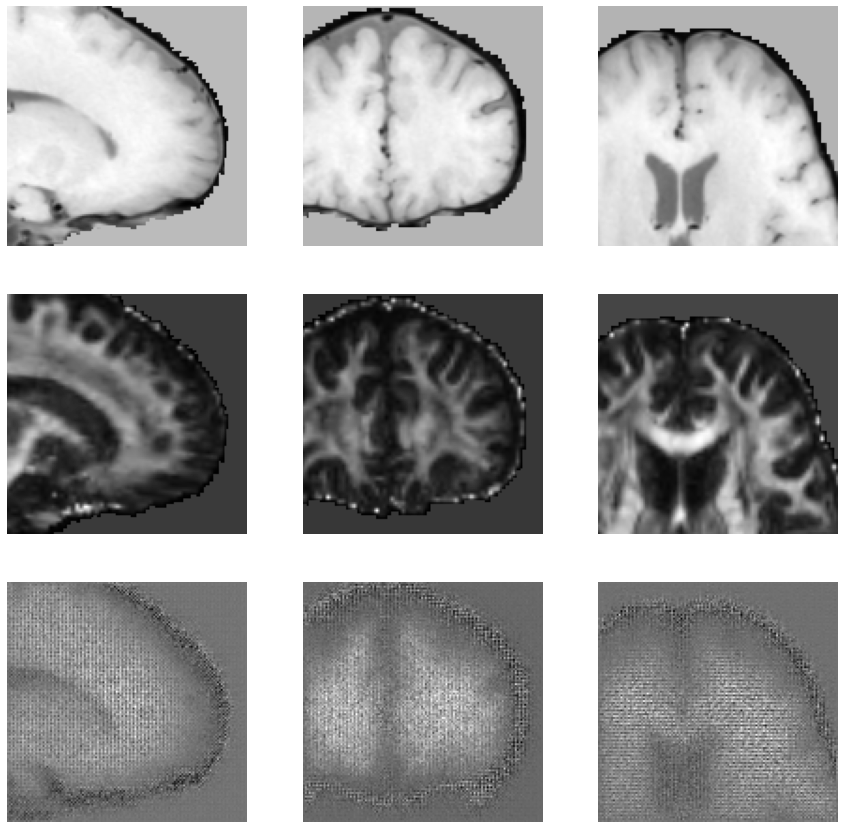

Validation loss decresaed from inf to -10.5213. Models' weights are now saved.
Epoch 2/10
Step: 2/10 - loss: -9.404614 - dice_loss: -2.092910 - gan_disc_loss: 1.059935 - disc_loss: 0.820111Time taken for 1 steps: 111.62 sec

Epoch 6/10
Step: 6/10 - loss: -13.065510 - dice_loss: -2.811951 - gan_disc_loss: 0.994247 - disc_loss: 0.784008Time taken for 1 steps: 40.11 sec

Epoch 7/10
Step: 7/10 - loss: -14.704991 - dice_loss: -3.128909 - gan_disc_loss: 0.939555 - disc_loss: 0.771317Time taken for 1 steps: 104.66 sec

Epoch 8/10
Step: 8/10 - loss: -16.433739 - dice_loss: -3.479300 - gan_disc_loss: 0.962763 - disc_loss: 0.794560Time taken for 1 steps: 33.79 sec

Val_step: 0/2 - val_loss: -18.916088 - val_dice_loss: -4.218615 - val_gan_disc_loss: 2.176985 - val_disc_loss: 1.670007(128, 128, 128) (128, 128, 128) (128, 128, 128, 1)


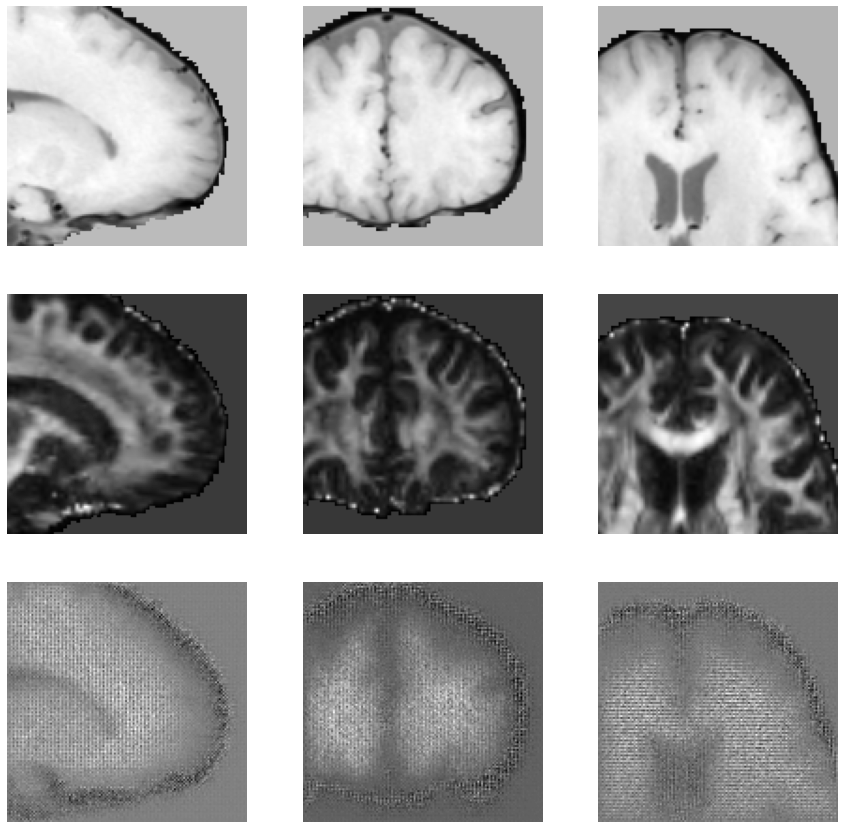

Validation loss decresaed from inf to -18.9161. Models' weights are now saved.
Epoch 2/10
Step: 2/10 - loss: -18.430073 - dice_loss: -3.994232 - gan_disc_loss: 1.541089 - disc_loss: 1.258195Time taken for 1 steps: 110.29 sec

Epoch 10/10
Step: 10/10 - loss: -23.715639 - dice_loss: -5.025654 - gan_disc_loss: 1.412632 - disc_loss: 1.132390Time taken for 1 steps: 43.13 sec



In [41]:
h=fit(train_ds,val_ds,steps=10)

In [42]:
h

{'train': [[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
  [<tf.Tensor: shape=(), dtype=float32, numpy=-8.537078>,
   <tf.Tensor: shape=(), dtype=float32, numpy=-1.9018586>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.97221434>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.92009354>],
  [<tf.Tensor: shape=(), dtype=float32, numpy=-16.433739>,
   <tf.Tensor: shape=(), dtype=float32, numpy=-3.4793005>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.96276283>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.79456025>]],
 'valid': [[<tf.Tensor: shape=(), dtype=float32, numpy=-4.046928>,
   <tf.Tensor: shape=(), dtype=float32, numpy=-1.0084543>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.9953434>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.91727865>],
  [<tf.Tensor: shape=(), dtype=float32, numpy=-10.521267>,
   <t

In [ ]:
#try tensor.map
train_dataset = tf.data.Dataset.from_tensor_slices(train)
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
    return t.decode('utf-8')+"1",t.decode('utf-8')+"2"
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
        #   inp=[x], Tout=tf.string))
# list(d.as_numpy_iterator())
train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))
# train_dataset=train_dataset.map(lambda x:tf.strings.as_string(x)+"2")
list(train_dataset.as_numpy_iterator())
# len(train_dataset.map(np.array))
# for i in train_dataset:
    # print()#.numpy())


In [ ]:
from numpy.random import randint
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return (t.decode('utf-8')+str(randint(10))).upper()
d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
          inp=[x], Tout=tf.string),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
list(d.repeat().take(10).as_numpy_iterator())
# list(d.as_numpy_iterator())

[b'HELLO3',
 b'WORLD3',
 b'HELLO9',
 b'WORLD2',
 b'HELLO9',
 b'WORLD5',
 b'HELLO4',
 b'WORLD2',
 b'HELLO8',
 b'WORLD2']

In [ ]:
class A:
    def __init__(self):
        self.t=10
    def exec(self,b):
        self.t+=b
a=[A()for i in range(4)]
b=[i for i in range(4)]
map(lambda x,y:x.exec(y),a,b)
a[2].t

12